## **1. Import the necessary libraries**
---

In [988]:
import datetime
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import os
import time as time
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from keras.models import load_model

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.8.3
numpy:       1.21.5
matplotlib:  3.5.1
sklearn:     1.0.2


## **2.Create a function to plot image without axis**
---

In [989]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

print(implt)

x = datetime.datetime.now()
filename = x.strftime("%Y") + x.strftime("%m") + x.strftime("%d") + x.strftime("%H") + x.strftime("%M")

<function implt at 0x000001D8374C0310>


## **3. Set matplotlib to have seaborn plot style**
---

In [990]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


In [991]:

SEED = 7
IMAGE_SIZE = 64
EPOCHS = 40
CHANNELS = 3
BATCH_SIZE = 32
KERNEL_REGULARIZER = 0.001
OPTIMIZERS = [optimizers.RMSprop(learning_rate=0.0001), optimizers.Adam(learning_rate=0.0001)]
OPT = 0

# **4.1 Downsize original images (Optional)**

In [992]:
image_size = IMAGE_SIZE

def resize_image(source_data_dir):
    data = []
    
    os.chdir(source_data_dir)
    
    for label in labels:
        path = source_data_dir
        # print(path)
        for image in os.listdir(path):
            if "downsized_" not in image:
                try:
                    # Convert BGR to RGB
                    image_array = cv2.imread(os.path.join(path, image))
                    # Resize image
                    resized_array = cv2.resize(image_array, (image_size, image_size))
                    cv2.imwrite("downsized_" + image, resized_array)
                except Exception as e:
                    print(e)

In [993]:
# resize_image('C:\Users\jerem\VirtualBox VMs\Ubuntu\Shared\IRS_Project\GitHub\PRMLS_Project\SystemCode\dataset\Cleaned\BettaBGReduc')
# 'C:\\Users\\jerem\\VirtualBox VMs\\Ubuntu\\Shared\\IRS_Project\\GitHub\\PRMLS_Project\\SystemCode\\dataset\\FishOrNotFishReducedabc_2\\Test\\Fish')

In [994]:
print(os.getcwd())

C:\Users\jerem\VirtualBox VMs\Ubuntu\Shared\IRS_Project\GitHub\PRMLS_Project\SystemCode


# **4.2 Prepare Fish Or Not Fish data for training and testing**

In [995]:
# LABELS = [
#     'Fish',
#     'NotFish'
# ]

LABELS = [
    'Target',
    'NotTarget'
]

In [996]:
image_size = IMAGE_SIZE

def get_data(data_dir):
    data = []
    
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_number = LABELS.index(label)
        
        for image in os.listdir(path):
            try:
                # Convert BGR to RGB
                image_array = cv2.imread(os.path.join(path, image))[...,::-1]
                # Resize image
                resized_array = cv2.resize(image_array, (image_size, image_size))
                resized_array = resized_array / 255.0
                                
                data.append([resized_array, class_number])
                
            
            except Exception as e:
                print(e)
                
    return np.array(data)
    
# Fetch Train and Test Data
train = get_data("C:\\Users\\jerem\\VirtualBox VMs\\Ubuntu\\Shared\\IRS_Project\\GitHub\\PRMLS_Project\\SystemCode\\dataset\\TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish\\Train")
val = get_data("C:\\Users\\jerem\\VirtualBox VMs\\Ubuntu\\Shared\\IRS_Project\\GitHub\\PRMLS_Project\\SystemCode\\dataset\\TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish\\Test")

C:\Users\jerem\AppData\Local\Temp\ipykernel_3032\1996377456.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [997]:
print(train.shape)

(9000, 2)


In [998]:
l = []

for i in train:
    l.append(LABELS[i[1]])

9000


C:\Users\jerem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

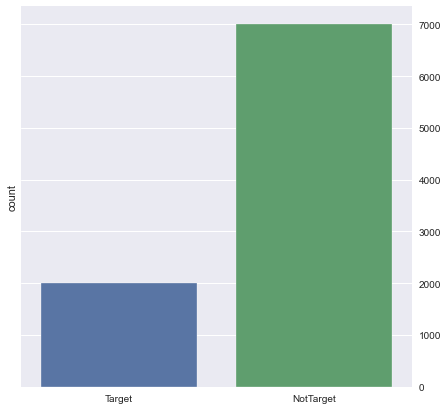

In [999]:
print(len(l))

sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'Target')

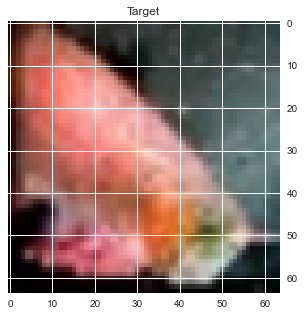

In [1000]:
plt.figure(figsize = (5, 5))
plt.imshow(train[0][0])
plt.title(LABELS[train[0][1]])

Text(0.5, 1.0, 'NotTarget')

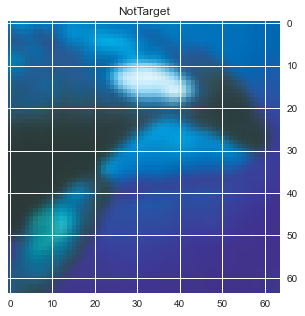

In [1001]:
plt.figure(figsize = (5, 5))
plt.imshow(train[3999][0])
plt.title(LABELS[train[3999][1]])

## **5. Perform Pre-Processing and Augmentation**

In [1002]:
x_train = []
y_train = []

x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [1003]:
# Store copy of y_train
Y = y_train

# Convert to Numpy
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_val)
y_val = np.array(y_val)
# Keras provides numpy utility library, which provides functions to perform actions on numpy arrays.
# Using the method to_categorical(), a numpy array (or) a vector which has integers that represent
# different categories, can be converted into a numpy array (or) a matrix which has binary values and
# has columns equal to the number of categories in the data. (One Hot Encoding)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [1004]:
print(x_train.shape)
print(x_val.shape)

(9000, 64, 64, 3)
(1800, 64, 64, 3)


In [1005]:
print(y_train.shape)
print(y_val.shape)

(9000, 2)
(1800, 2)


In [1006]:
image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     # layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

## **6. Define the Model**

In [1007]:
seed = 29
np.random.seed(seed)

optmz       = OPTIMIZERS[OPT]                                      # Step 1
modelname   = 'Hybrid_Cifar100'                                                          # Step 2

image_height = IMAGE_SIZE  
image_width = IMAGE_SIZE
channel = CHANNELS
                                                                                # Step 3
def createModel():
    model = Sequential()

    model.add(image_augmentation)
    
    # Hybrid_best.hdf5
    
    # https://andrewkruger.github.io/projects/2017-08-05-keras-convolutional-neural-network-for-cifar-100
    # Phase 1A
#     model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (image_height, image_width, channel), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(128, activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))
#     model.add(Dense(len(LABELS), activation = 'softmax')) 
#     model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    # Phase 1B
#     model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (image_height, image_width, channel), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(256, (3, 3), padding='same', activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(512, (3, 3), padding='same', activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(512, activation = 'relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation = 'relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(len(LABELS), activation = 'softmax')) 
#     model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    

    
    # Phase 2A
#     model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (image_height, image_width, channel), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(128, activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))
#     model.add(Dense(len(LABELS), activation = 'softmax')) 
#     model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])    
    # Phase 2B - Only 4 Classifications wrong
#     model.add(Conv2D(64, (9, 9), padding = 'same', input_shape = (image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Conv2D(128, (9, 9), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(256, (9, 9), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))
#     model.add(Dense(len(LABELS), activation = 'softmax')) 
#     model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])  
    
    # Phase 3
    model.add(Conv2D(64, (13, 13), padding = 'same', input_shape = (image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    # model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])  
    
### Last    
#     # Works best on 3_3
#     model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(128, activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))
#     model.add(Dense(len(LABELS), activation = 'softmax'))  
#     model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
### Last
    
    
#     # Works best on 3_3
#     model.add(Conv2D(32, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(64, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))
#     # model.add(Dense(128, activation = 'relu'))
#     model.add(Dense(len(LABELS), activation = 'softmax'))  
#     model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
    
    
    # model.add(Conv2D(512, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.0001), activation = 'relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # model.add(Conv2D(1024, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.0001), activation = 'relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # model.add(Flatten())
    
    # model.add(Dense(2048, activation = 'relu'))
    # model.add(Dense(1028, activation = 'relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(512, activation = 'relu'))
    
    # model.add(Dense(256, activation = 'relu'))
    # model.add(Dropout(0.1))
    # model.add(Dense(len(LABELS), activation = 'softmax'))  
    
    
    
    
    
    
    
#     model.add(Conv2D(64, (3, 3), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))

#     model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))
    
#     model.add(Conv2D(16, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))
    
    
    
    
    
    
    
    
    
#     model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))
    
#     model.add(Conv2D(512, (3, 3), padding = 'same', input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))

#     model.add(Conv2D(256, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))

#     model.add(Conv2D(128, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))
    
#     model.add(Conv2D(64, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))
    
#     model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.1))
    
    
    
    
    
    
    
        
#     model.add(Conv2D(32, (3, 3), padding = 'same', input_shape=(image_height, image_width, channel), kernel_initializer='he_normal', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
    
#     model.add(Conv2D(64, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
    
#     model.add(Conv2D(128, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
    
#     model.add(Conv2D(256, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
    
#     model.add(Conv2D(512, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

#     model.add(Conv2D(1024, (3, 3), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    # model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(1028, activation = 'relu'))
#     model.add(Dropout(0.5))
# #     model.add(Dense(256, activation = 'relu'))
# #     model.add(Dropout(0.2))
#     model.add(Dense(100, activation = 'relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(len(labels), activation = 'softmax'))

    # model.compile(loss = 'binary_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    # model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    # model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer = optmz, metrics = ['accuracy'])

    return model

                                                                                # Step 4
model       = createModel()   # This is meant for training
modelGo     = createModel()   # This is used for final testing

model.summary()                                                                 # Step 5

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_87 (Sequential)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_174 (Conv2D)         (None, 64, 64, 64)        32512     
                                                                 
 max_pooling2d_174 (MaxPooli  (None, 32, 32, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_175 (Conv2D)         (None, 32, 32, 128)       1384576   
                                                                 
 max_pooling2d_175 (MaxPooli  (None, 16, 16, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_176 (Conv2D)         (None, 16, 16, 256)     



## **7. Create the callbacks to be applied during training**
---
* Step 1: Create a callback to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a callback to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two callbacks objects into a list

In [1008]:
folderpath      = "C:\\Users\\jerem\\VirtualBox VMs\\Ubuntu\\Shared\\IRS_Project\\GitHub\\PRMLS_Project\\SystemCode\\models\\"# '/content/gdrive/My Drive/iss/prumls/colab/'
MODELFILENAME =  modelname + "_" + filename + ".hdf5"
print("Model Name: ",)
# filepath        = folderpath + modelname + "_" + filename + ".hdf5"
filepath = folderpath + MODELFILENAME
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath + modelname + "_" + filename + ".csv")                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath + modelname + "_" + filename + ".csv")

Model Name: 
Callbacks created:

Path to model: C:\Users\jerem\VirtualBox VMs\Ubuntu\Shared\IRS_Project\GitHub\PRMLS_Project\SystemCode\models\Hybrid_Cifar100_202211020537.hdf5
Path to log:   C:\Users\jerem\VirtualBox VMs\Ubuntu\Shared\IRS_Project\GitHub\PRMLS_Project\SystemCode\models\Hybrid_Cifar100_202211020537.csv


## **8. Train the deep learning model**
___

In [1009]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = Y                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
customized_class_weights = class_weights

# 

In [1010]:
print(class_weights)
print(customized_class_weights)
validation_weights = [0.1167, 7]

{0.0: 2.25, 1.0: 0.6428571428571429}
{0.0: 2.25, 1.0: 0.6428571428571429}


In [1011]:
# cusomterized_class_weights = class_weights
# cusomterized_class_weights = {0: 1.0, 1: 1.0}

In [1012]:
start = time.time()

history = model.fit(x_train,                            # Training data
          y_train,                            # Training label
          validation_data = (x_val, y_val),   # Validation data and label
          epochs = EPOCHS,                       # The amount of epochs to be trained
          batch_size = BATCH_SIZE,                   
          shuffle = True,                     # To shuffle the training data
          callbacks = callbacks_list,         # Callbacks to execute the checkpoints
          class_weight = customized_class_weights)

end = time.time()
duration = round(((end - start) / 60), 2)
print("Duration to train ", EPOCHS, " epochs is ", duration, " minutes")

# history = model.fit(datagen.flow(x_train, y_train, batch_size = 32),                            # Training data
#           validation_data = (x_val, y_val),   # Validation data and label
#           steps_per_epoch = len(x_train) // 32,
#           epochs = 50,                       # The amount of epochs to be trained              
#           shuffle = True,                     # To shuffle the training data
#           callbacks = callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/40
282/282 [==============================] - 8s 24ms/step - loss: 1.2319 - accuracy: 0.7854 - val_loss: 1.1735 - val_accuracy: 0.6672
Epoch 2/40
282/282 [==============================] - 7s 23ms/step - loss: 0.8217 - accuracy: 0.8754 - val_loss: 0.7967 - val_accuracy: 0.9072
Epoch 3/40
282/282 [==============================] - 6s 23ms/step - loss: 0.6641 - accuracy: 0.8993 - val_loss: 1.0572 - val_accuracy: 0.6833
Epoch 4/40
282/282 [==============================] - 7s 23ms/step - loss: 0.5926 - accuracy: 0.9058 - val_loss: 0.5342 - val_accuracy: 0.9222
Epoch 5/40
282/282 [==============================] - 7s 24ms/step - loss: 0.5316 - accuracy: 0.9133 - val_loss: 0.4704 - val_accuracy: 0.9394
Epoch 6/40
282/282 [==============================] - 6s 23ms/step - loss: 0.4973 - accuracy: 0.9267 - val_loss: 0.5016 - val_accuracy: 0.9228
Epoch 7/40
282/282 [==============================] - 6s 23ms/step - loss: 0.4679 - accuracy: 0.9283 - val_loss: 0.6017 - val_accuracy: 0.8844

## **9. Evaluate Results**
---

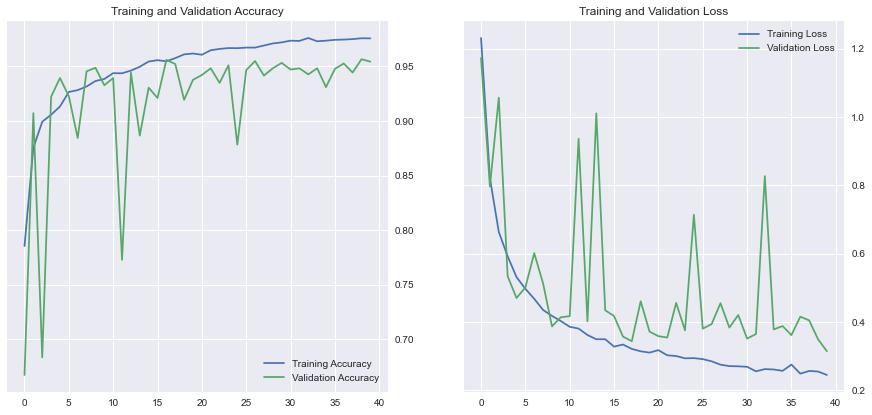

In [1013]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


## **10. Review classification metrics**
---


In [1014]:
print(x_val.shape)
print(y_val.shape)

(1800, 64, 64, 3)
(1800, 2)


In [1015]:
modelGo.load_weights(filepath)
modelGo.compile(loss = 'categorical_crossentropy', 
                optimizer = optmz, 
                metrics=['accuracy'])

predicts = modelGo.predict(x_val)
print("Prediction completes.")

Prediction completes.


In [1016]:
print(predicts.shape)

(1800, 2)


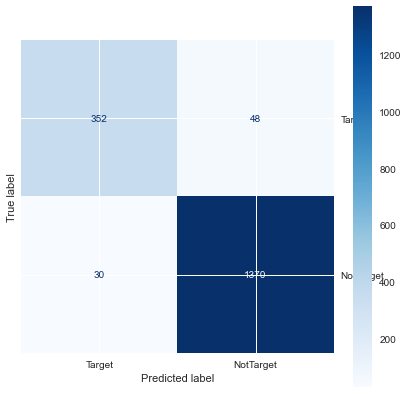

In [1017]:
cm = confusion_matrix(y_val.argmax(axis = 1), predicts.argmax(axis = 1))

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = LABELS)

disp.plot(cmap = plt.cm.Blues)
plt.show()

In [1018]:
predout     = np.argmax(predicts, axis = 1)
testout     = np.argmax(y_val, axis = 1)

testScores  = metrics.accuracy_score(testout, predout)                           # Step 3
                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names = LABELS,
                                    digits = 4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names = LABELS,
                                    digits=4,
                                      output_dict=True)

confusion = metrics.confusion_matrix(testout, predout)

print("\n\n")
print(confusion)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath + modelname + '_report.csv')

Best accuracy (on testing dataset): 95.67%
              precision    recall  f1-score   support

      Target     0.9215    0.8800    0.9003       400
   NotTarget     0.9661    0.9786    0.9723      1400

    accuracy                         0.9567      1800
   macro avg     0.9438    0.9293    0.9363      1800
weighted avg     0.9562    0.9567    0.9563      1800




[[ 352   48]
 [  30 1370]]


In [1019]:
# resdf = pd.DataFrame()
# resdf["file"] = x_val
# resdf["fish"] = y_val

# resdf["testout"] = testout
# resdf["predout"] = predout

# wrong_pred = resdf[resdf.testout !=resdf.predout]
# wrong_pred

## **13. Save the model plot**
---

In [1020]:
plotpath  = folderpath + modelname + "_" + filename + '_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: C:\Users\jerem\VirtualBox VMs\Ubuntu\Shared\IRS_Project\GitHub\PRMLS_Project\SystemCode\models\Hybrid_Cifar100_202211020537_plot.png


In [1021]:
##############################################################################################################################
##############################################################################################################################
##############################################################################################################################
##############################################################################################################################
##############################################################################################################################
##############################################################################################################################
##############################################################################################################################

In [1022]:
# Good Models
# Hybrid_Cifar100_202210042314 (Cifar_Mixed_3)
# Hybrid_Cifar100_202210050043 (Cifar_Mixed_3_3)
# Hybrid_Cifar100_202210052133 (Cifar_Mixed_3_3) BEST
# Hybrid_Cifar100_202210062242 (Cifar_Mixed_3_3)
# model_file = filepath
# model_file = "C:\\Users\\jerem\\VirtualBox VMs\\Ubuntu\\Shared\\IRS_Project\\GitHub\\PRMLS_Project\\SystemCode\\models\\Hybrid_Cifar100_202210241113.hdf5"
model_file = filepath

print(model_file)

image_height = IMAGE_SIZE
image_width = IMAGE_SIZE

def predict_new_image(image):
    image_name = image
    
    image = tf.keras.utils.load_img(image, target_size = None)#, keep_aspect_ratio = True)
    
    image_array = tf.keras.utils.img_to_array(image)
    image_array = tf.keras.preprocessing.image.smart_resize(image_array, size = (image_height, image_width))
    image_array = tf.expand_dims(image_array, 0)
    image_array = image_array / 255.0
    
    saved_model = load_model(model_file)
    
    predictions = saved_model.predict(image_array)
    score = tf.nn.softmax(predictions[0])
    
    #plt.imshow(image)
    #plt.show()
    
    print(image_name, 
        " most likely belongs to {} with a {:.2f} percent confidence."
        .format(LABELS[np.argmax(score)], 100 * np.max(score))
    )

C:\Users\jerem\VirtualBox VMs\Ubuntu\Shared\IRS_Project\GitHub\PRMLS_Project\SystemCode\models\Hybrid_Cifar100_202211020537.hdf5


In [1023]:
os.chdir("C:\\Users\\jerem\\VirtualBox VMs\\Ubuntu\\Shared\\IRS_Project\\GitHub\\PRMLS_Project\\SystemCode")

print("Model: ", MODELFILENAME)

# print("---------------------Alan's Data--------------------------")
# predict_new_image("validate/images/woman_1.jpg")
# predict_new_image("validate/images/woman_2.jpg")

# predict_new_image("validate/images/27.jpg")
# predict_new_image("validate/images/betta0609.jpg")
# predict_new_image("validate/images/betta0013.jpg")
# predict_new_image("validate/images/betta0139.jpg")
# predict_new_image("validate/images/betta0154.jpg")
# predict_new_image("validate/images/Arrowana10662.jpg")

# predict_new_image("validate/images/frame19230.jpg")
# predict_new_image("validate/images/20120701-0rwniuozab_v_1543018810.jpg")
# predict_new_image("validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg")
# predict_new_image("validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg")
# predict_new_image("validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg")
# predict_new_image("validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg")

# predict_new_image("validate/images/frame19230.jpg")
# predict_new_image("validate/images/frame17950.jpg")
# predict_new_image("validate/images/frame60.jpg")

# predict_new_image("validate/images/starfish_3.jpg")
# predict_new_image("validate/images/Starfish_Cropped.png")

# print("\n\n\n\n---------------------Fishes--------------------------")
# predict_new_image("validate/Report/Fish/fish.jpg")
# predict_new_image("validate/Report/Fish/shark.jpg")
# predict_new_image("validate/Report/Fish/betta.jpg")
# predict_new_image("validate/Report/Fish/betta1.jpg")
# predict_new_image("validate/Report/Fish/betta0154.jpg")
# predict_new_image("validate/Report/Fish/betta0154.jpg")
# predict_new_image("validate/Report/Fish/nemo.jpg")
# predict_new_image("validate/Report/Fish/flowerhorn-9.jpg")
# predict_new_image("validate/Report/Fish/fishbone.jpg")


# print("\n\n\n\n---------------------Non Fishes--------------------------")
# predict_new_image("validate/Report/Not Fish/acq.jpg")
# predict_new_image("validate/Report/Not Fish/jeremy.jpg")
# predict_new_image("validate/Report/Not Fish/tree.jpg")
# predict_new_image("validate/Report/Not Fish/cockroach.jpg")
# predict_new_image("validate/Report/Not Fish/starfish.jpg")
# predict_new_image("validate/Report/Not Fish/car.jpg")
# predict_new_image("validate/Report/Not Fish/whale.jpg")
# predict_new_image("validate/Report/Not Fish/beaver.jpg")
# predict_new_image("validate/Report/Not Fish/woman.jpg")
# predict_new_image("validate/Report/Not Fish/starfish2.jpg")
# predict_new_image("validate/Report/Not Fish/beaver2.jpg")
# predict_new_image("validate/Report/Not Fish/seal2.jpg")
# predict_new_image("validate/Report/Not Fish/seal3.jpg")
# predict_new_image("validate/Report/Not Fish/ball.jpg")
# predict_new_image("validate/Report/Not Fish/brush.jpg")
# predict_new_image("validate/Report/Not Fish/Starfish_Cropped.png")


print("\n\n\n\n---------------------Test--------------------------")
print("---------------------------Target--------------------------")

predict_new_image("validate/betta.jpg")
predict_new_image("validate/betta1.jpg")
predict_new_image("validate/betta0154.jpg")
predict_new_image("validate/flowerhorn-9.jpg")
predict_new_image("validate/7-74036_goldfish-png-transparent-image-real-fish-png.jpg")
predict_new_image("validate/Arrowana10259.jpg")
predict_new_image("validate/3d0b28429a4c2ecb.jpg")
predict_new_image("validate/20120701-0rwniuozab_v_1543018810.jpg")

print("---------------------------Not Target----------------------")
predict_new_image("validate/nemo.jpg")
predict_new_image("validate/fish.jpg")
predict_new_image("validate/shark.jpg")
predict_new_image("validate/Report/Fish/fishbone.jpg")
predict_new_image("validate/acq.jpg")
predict_new_image("validate/ball.jpg")
predict_new_image("validate/beaver.jpg")
predict_new_image("validate/brush.jpg")
predict_new_image("validate/car.jpg")
predict_new_image("validate/cockroach.jpg")
predict_new_image("validate/man.jpg")
predict_new_image("validate/starfish.jpg")
predict_new_image("validate/tree.jpg")
predict_new_image("validate/seal.jpg")
predict_new_image("validate/woman.jpg")
predict_new_image("validate/whale.jpg")

Model:  Hybrid_Cifar100_202211020537.hdf5




---------------------Test--------------------------
---------------------------Target--------------------------
validate/betta.jpg  most likely belongs to NotTarget with a 59.53 percent confidence.
validate/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Target with a 73.01 percent confidence.
validate/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to NotTarget with a 68.55 percent confidence.
validate/Arrowana10259.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/3d0b28429a4c2ecb.jpg  most likely belongs to NotTarget with a 68.41 percent confidence.
validate/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 52.59 percent confidence.
---------------------------Not Target----------------------
v

In [ ]:
    model.add(Conv2D(64, (13, 13), padding = 'same', input_shape = (image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy']) 
    
Model:  Hybrid_Cifar100_202211020435.hdf5




---------------------Test--------------------------
---------------------------Target--------------------------
validate/betta.jpg  most likely belongs to NotTarget with a 63.34 percent confidence.
validate/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Target with a 72.26 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Arrowana10259.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/3d0b28429a4c2ecb.jpg  most likely belongs to Target with a 72.35 percent confidence.
validate/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 53.15 percent confidence.
---------------------------Not Target----------------------
validate/nemo.jpg  most likely belongs to Target with a 67.39 percent confidence.
validate/fish.jpg  most likely belongs to NotTarget with a 71.91 percent confidence.
validate/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 70.81 percent confidence.
validate/acq.jpg  most likely belongs to NotTarget with a 72.78 percent confidence.
validate/ball.jpg  most likely belongs to NotTarget with a 72.93 percent confidence.
validate/beaver.jpg  most likely belongs to NotTarget with a 72.46 percent confidence.
validate/brush.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/man.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/starfish.jpg  most likely belongs to NotTarget with a 71.52 percent confidence.
validate/tree.jpg  most likely belongs to Target with a 67.79 percent confidence.
validate/seal.jpg  most likely belongs to NotTarget with a 70.80 percent confidence.
validate/woman.jpg  most likely belongs to NotTarget with a 70.70 percent confidence.
validate/whale.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.

In [ ]:
    model.add(Conv2D(64, (9, 9), padding = 'same', input_shape = (image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (9, 9), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])  
    
Model:  Hybrid_Cifar100_202211020402.hdf5




---------------------Test--------------------------
---------------------------Target--------------------------
validate/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Arrowana10259.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/3d0b28429a4c2ecb.jpg  most likely belongs to Target with a 72.71 percent confidence.
validate/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 60.34 percent confidence.
---------------------------Not Target----------------------
validate/nemo.jpg  most likely belongs to Target with a 73.01 percent confidence.
validate/fish.jpg  most likely belongs to Target with a 73.00 percent confidence.
validate/shark.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/acq.jpg  most likely belongs to NotTarget with a 71.80 percent confidence.
validate/ball.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/beaver.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/brush.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/car.jpg  most likely belongs to NotTarget with a 64.63 percent confidence.
validate/cockroach.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/man.jpg  most likely belongs to NotTarget with a 62.48 percent confidence.
validate/starfish.jpg  most likely belongs to Target with a 61.30 percent confidence.
validate/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotTarget with a 63.84 percent confidence.
validate/woman.jpg  most likely belongs to NotTarget with a 61.41 percent confidence.
validate/whale.jpg  most likely belongs to NotTarget with a 68.55 percent confidence.

In [ ]:
    model.add(Conv2D(64, (13, 13), padding = 'same', input_shape = (image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy']) 

---------------------Test--------------------------
---------------------------Target--------------------------
validate/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Target with a 72.72 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 68.45 percent confidence.
validate/Arrowana10259.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/3d0b28429a4c2ecb.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 51.49 percent confidence.
---------------------------Not Target----------------------
validate/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/fish.jpg  most likely belongs to NotTarget with a 71.55 percent confidence.
validate/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/acq.jpg  most likely belongs to NotTarget with a 72.81 percent confidence.
validate/ball.jpg  most likely belongs to NotTarget with a 72.34 percent confidence.
validate/beaver.jpg  most likely belongs to NotTarget with a 72.55 percent confidence.
validate/brush.jpg  most likely belongs to NotTarget with a 72.92 percent confidence.
validate/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Target with a 72.92 percent confidence.
validate/man.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/starfish.jpg  most likely belongs to Target with a 72.72 percent confidence.
validate/tree.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/seal.jpg  most likely belongs to NotTarget with a 72.21 percent confidence.
validate/woman.jpg  most likely belongs to NotTarget with a 60.27 percent confidence.
validate/whale.jpg  most likely belongs to Target with a 62.53 percent confidence.


In [ ]:
    model.add(Conv2D(64, (13, 13), padding = 'same', input_shape = (image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])  
    
---------------------Test--------------------------
---------------------------Target--------------------------
validate/betta.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Target with a 70.88 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 62.19 percent confidence.
validate/Arrowana10259.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/3d0b28429a4c2ecb.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 71.93 percent confidence.
---------------------------Not Target----------------------
validate/nemo.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/fish.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to NotTarget with a 56.84 percent confidence.
validate/acq.jpg  most likely belongs to NotTarget with a 72.54 percent confidence.
validate/ball.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/beaver.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/man.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/starfish.jpg  most likely belongs to Target with a 57.66 percent confidence.
validate/tree.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/seal.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/woman.jpg  most likely belongs to NotTarget with a 72.49 percent confidence.
validate/whale.jpg  most likely belongs to Target with a 72.75 percent confidence.

In [ ]:
    model.add(Conv2D(64, (13, 13), padding = 'same', input_shape = (image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
Model:  Hybrid_Cifar100_202211020305.hdf5




---------------------Test--------------------------
---------------------------Target--------------------------
validate/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Target with a 73.02 percent confidence.
validate/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Arrowana10259.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/3d0b28429a4c2ecb.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 61.45 percent confidence.
---------------------------Not Target----------------------
validate/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/fish.jpg  most likely belongs to Target with a 68.00 percent confidence.
validate/shark.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/acq.jpg  most likely belongs to NotTarget with a 72.73 percent confidence.
validate/ball.jpg  most likely belongs to Target with a 56.17 percent confidence.
validate/beaver.jpg  most likely belongs to Target with a 65.11 percent confidence.
validate/brush.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/car.jpg  most likely belongs to Target with a 72.47 percent confidence.
validate/cockroach.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/man.jpg  most likely belongs to NotTarget with a 72.87 percent confidence.
validate/starfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotTarget with a 72.55 percent confidence.
validate/woman.jpg  most likely belongs to NotTarget with a 72.76 percent confidence.
validate/whale.jpg  most likely belongs to Target with a 72.90 percent confidence.
    

In [ ]:
    model.add(Conv2D(64, (9, 9), padding = 'same', input_shape = (image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (9, 9), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding='same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax')) 
    model.compile(loss='categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])  

---------------------Test--------------------------
---------------------------Target--------------------------
validate/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Arrowana10259.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/3d0b28429a4c2ecb.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 69.78 percent confidence.
---------------------------Not Target----------------------
validate/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/fish.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/acq.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/ball.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/brush.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/car.jpg  most likely belongs to Target with a 72.75 percent confidence.
validate/cockroach.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/man.jpg  most likely belongs to NotTarget with a 70.14 percent confidence.
validate/starfish.jpg  most likely belongs to Target with a 73.02 percent confidence.
validate/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to Target with a 70.39 percent confidence.
validate/woman.jpg  most likely belongs to NotTarget with a 72.56 percent confidence.
validate/whale.jpg  most likely belongs to NotTarget with a 72.99 percent confidence.


In [ ]:
    model = Sequential()
    model.add(image_augmentation)
    model.add(Conv2D(64, (5,5), padding='same', input_shape=(160,160,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (4,4), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish

    model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
Model:  Hybrid_Cifar100_202210292354.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to Target with a 62.09 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001E2BC190EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001E2BC6B70D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 72.99 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 70.54 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 61.43 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 72.91 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.03 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.64 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 62.37 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 69.95 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 53.74 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.14 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.41 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 53.87 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 72.84 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_5_2_CleanedTargetWithCifarFish_UpdatedBettaOnly
    # Works best on 3_3
    model.add(Conv2D(32, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    # model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210292306.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002C856E6BC10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002C85702A5E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 56.00 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.03 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to NotTarget with a 72.81 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 53.87 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.01 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.56 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 65.98 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.00 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 63.76 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.03 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 71.97 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.32 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 72.88 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 70.57 percent confidence.

In [35]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish
# Works best on 3_3
    model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    


Model:  Hybrid_Cifar100_202210292141.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.54 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000250D881B0D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 72.78 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000250D881B9D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 66.16 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 72.13 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to NotTarget with a 59.45 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.87 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 68.43 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 68.28 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 72.07 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.87 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.04 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.81 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 72.84 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 66.79 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 71.76 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 66.90 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 66.90 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to NotTarget with a 63.81 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 70.69 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.01 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 69.72 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.86 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 70.28 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 67.82 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.19 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 71.58 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.78 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 64.97 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 58.47 percent confidence.

IndentationError: unexpected indent (269454031.py, line 3)

In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish
# Works best on 3_3
    model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210292133.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.55 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000279D660ACA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.10 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000279D6B3B040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 57.67 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 70.51 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to NotTarget with a 56.66 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.46 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 55.83 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.99 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 72.64 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.44 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.46 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.35 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 53.72 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 72.35 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 67.61 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 71.77 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to NotTarget with a 61.05 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 69.09 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 69.09 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 67.47 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 72.18 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.10 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 57.79 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 72.70 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 70.49 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 60.87 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 72.50 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 71.91 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 71.26 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 64.61 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.16 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 67.13 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.01 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 55.47 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish

    # Works best on 3_3
    model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    


Model:  Hybrid_Cifar100_202210292125.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 66.97 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000019CD93EC280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000019CDA89C4C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 60.84 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.39 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 64.37 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 72.59 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to Target with a 50.32 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 72.26 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.84 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to Target with a 71.14 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.08 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 72.38 percent confidence.


In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish
model.add(Conv2D(32, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    # model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])


Model:  Hybrid_Cifar100_202210292112.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001945A029C10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001945A1FB430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.94 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 72.81 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 71.57 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.99 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 72.42 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.94 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.99 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.00 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to NotTarget with a 70.58 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 69.57 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to NotTarget with a 72.14 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 71.88 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 71.88 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 64.62 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 72.95 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 70.95 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 71.79 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 72.57 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 51.79 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 73.01 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 72.90 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 51.93 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish
model.add(Conv2D(32, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    # model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])


Model:  Hybrid_Cifar100_202210292107.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001BF55E91160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.07 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001BF563A5E50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.97 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 65.22 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 60.58 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 57.73 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to NotTarget with a 61.91 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 71.63 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 69.64 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 72.38 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 69.73 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 55.49 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 55.49 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to NotTarget with a 72.40 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 69.64 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 69.81 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 73.04 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.86 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.00 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 62.07 percent confidence.

In [ ]:
 TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish
    model.add(Conv2D(32, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210292100.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.74 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000199D824B3A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.05 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000199D824BC10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.78 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 72.58 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.04 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 71.87 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.20 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 64.55 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.83 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.04 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to NotTarget with a 69.62 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 69.56 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to NotTarget with a 58.10 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 72.93 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 70.94 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 53.19 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.72 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.40 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 72.82 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 58.42 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_5_CleanedTargetWithCifarFishAndCleanedDataset

    # Works best on 3_3
    model.add(Conv2D(64, (7, 7), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (7, 7), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (7, 7), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210292054.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Target with a 70.64 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Target with a 68.16 percent confidence.
validate/images/betta0139.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 72.31 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 69.81 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 63.98 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to NotTarget with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to Target with a 63.55 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 72.93 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 72.36 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to Target with a 71.23 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to Target with a 64.78 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 73.10 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_5_CleanedTargetWithCifarFishAndCleanedDataset

    # Works best on 3_3
    model.add(Conv2D(32, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
Model:  Hybrid_Cifar100_202210292041.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Target with a 71.97 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.76 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000020757668040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000020757668DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 65.95 percent confidence.
validate/images/betta0139.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 71.98 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.99 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 54.55 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to NotTarget with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 72.67 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 68.71 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 72.81 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 72.81 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 72.67 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 65.89 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.12 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to Target with a 69.58 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to Target with a 53.79 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 71.70 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 67.68 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 73.11 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_5_CleanedTargetWithCifarFishAndCleanedDataset

    # Works best on 3_3
    model.add(Conv2D(32, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210292029.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Target with a 68.62 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 72.94 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024256BFC430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024258BA00D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/betta0139.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotTarget with a 71.58 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.02 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 72.69 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 69.24 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to NotTarget with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 63.99 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 61.06 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 61.06 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.10 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 71.63 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 62.31 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 72.75 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.90 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.84 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.33 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 60.08 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 73.11 percent confidence.

In [ ]:
    # Works best on 3_3
    model.add(Conv2D(32, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210272327.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000015ADA2AB310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.08 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000015ADA29BE50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 69.13 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotTarget with a 64.61 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 72.45 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.93 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 64.06 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 51.13 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to NotTarget with a 66.84 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.97 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.93 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.04 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 72.32 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 72.68 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 66.37 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 66.37 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 72.65 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.00 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 56.64 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.90 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 71.13 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 64.09 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.73 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 53.22 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 71.86 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.37 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.00 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 72.43 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 52.11 percent confidence.
​

In [ ]:
    model.add(Conv2D(32, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210272312.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Target with a 72.86 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.67 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotTarget with a 68.12 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 72.96 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 67.62 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to NotTarget with a 63.83 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 72.51 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 72.86 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 54.12 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 67.94 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 67.94 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 72.51 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 72.43 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 72.37 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 64.85 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.91 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 72.25 percent confidence.

In [ ]:
# Promising
    # Works best on 3_3
    model.add(Conv2D(32, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210272306.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.86 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.94 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001FA3D6C1790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 60.66 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001FA3D74B430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 56.74 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 65.31 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.18 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 50.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 68.70 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 66.89 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 54.19 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.18 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.99 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 68.97 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to NotTarget with a 56.72 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 70.92 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 70.76 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 69.78 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 69.78 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to NotTarget with a 68.63 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.06 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 71.47 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 65.22 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.70 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 64.40 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 71.49 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 73.01 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 70.99 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.59 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 71.20 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 71.70 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 51.22 percent confidence.
​




In [ ]:
    # Works best on 3_3
    model.add(Conv2D(16, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

odel:  Hybrid_Cifar100_202210272302.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000022EBCCE3790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to NotTarget with a 62.62 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000022EBD09B430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 72.64 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotTarget with a 70.39 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 72.44 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to NotTarget with a 66.42 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 71.50 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 71.44 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 71.35 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 71.26 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 71.26 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.10 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.04 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 57.96 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to NotTarget with a 66.19 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 72.43 percent confidence.

In [ ]:
EPOCHS = 40
CHANNELS = 3
BATCH_SIZE = 32
KERNEL_REGULARIZER = 0.00115

    # Works best on 3_3
    model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    

Model:  Hybrid_Cifar100_202210272124.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001D84A3E4D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001D84A4FC310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.09 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 72.85 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.09 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 66.60 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 50.61 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.09 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.94 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 71.18 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 72.89 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 71.76 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 72.80 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 56.20 percent confidence.

In [ ]:
EPOCHS = 40
CHANNELS = 3
BATCH_SIZE = 32
KERNEL_REGULARIZER = 0.00115


    # Works best on 3_3
    model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210272102.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002A9B73380D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002A9B7338CA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 67.51 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 70.61 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.76 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 55.75 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 71.13 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.76 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 69.39 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 52.39 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.03 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 70.58 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 67.14 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 69.47 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 71.30 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 71.51 percent confidence.

In [26]:
EPOCHS = 40
CHANNELS = 3
BATCH_SIZE = 32
KERNEL_REGULARIZER = 0.00115
    # Works best on 3_3
    model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
Model:  Hybrid_Cifar100_202210252339.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001573BBC1C10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.03 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001573BCA1D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.97 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 62.76 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 72.92 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.77 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 68.15 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.24 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 70.56 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 67.72 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.77 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 72.19 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 69.40 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 72.74 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 72.49 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 51.06 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 58.99 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 72.97 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 70.43 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 54.55 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.69 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 71.99 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 66.35 percent confidence.

IndentationError: unexpected indent (1729926506.py, line 6)

In [ ]:
EPOCHS = 40
CHANNELS = 3
BATCH_SIZE = 32
KERNEL_REGULARIZER = 0.00115

# Works best on 3_3
    model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210252339.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001573BBC1C10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.03 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001573BCA1D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.97 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 62.76 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 72.92 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.77 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 68.15 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.24 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 70.56 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 67.72 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.77 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 72.19 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 69.40 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 72.74 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 72.49 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 51.06 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 58.99 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 72.97 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 70.43 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 54.55 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.69 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 71.99 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 66.35 percent confidence.

In [ ]:
# Kernel 15 hurts the details of the Target Class, giving more gravity to the NotTarget Class
# TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish

EPOCH = 50

KERNEL_REGULARIZER = 0.00115

image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     # layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

    # Works best on 3_3
    model.add(Conv2D(64, (15, 15), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (15, 15), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (15, 15), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210252318.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.89 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000142DFA29280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.02 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001463D82B790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.97 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotTarget with a 67.24 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 62.94 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.30 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 55.60 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 70.41 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.02 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 70.58 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.30 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.99 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 57.91 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to NotTarget with a 71.58 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 72.83 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 68.14 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 68.14 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 72.57 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 71.03 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.09 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 66.82 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 72.64 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.80 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 61.58 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.67 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.82 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 72.35 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 73.01 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish

EPOCH = 50

KERNEL_REGULARIZER = 0.00115

image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     # layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

    model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210252303.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.83 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.74 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001BD3D53FA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001BD3D5A5DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 67.31 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.62 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 71.40 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 71.57 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 68.30 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.45 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.62 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.93 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.92 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 71.90 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 72.44 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 72.29 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 66.33 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.79 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 65.95 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.49 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 62.87 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.01 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.50 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.04 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 70.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 70.37 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish

EPOCH = 50

image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     # layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)


    # Works best on 3_3
    model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210252233.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 71.89 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 72.41 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 66.38 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 62.33 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 70.18 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 71.02 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.94 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.45 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 70.65 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 71.04 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 72.85 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to Target with a 73.00 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 70.36 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to Target with a 66.12 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 72.34 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish

EPOCH = 50

image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     # layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

    # Works best on 3_3
    model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
Model:  Hybrid_Cifar100_202210252221.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.35 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 71.28 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.80 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 56.96 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 64.10 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 63.87 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.80 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.00 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.97 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 69.60 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 72.61 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to Target with a 72.57 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 64.94 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 71.25 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 69.43 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.04 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 63.78 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 66.57 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish

EPOCH = 25

image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     # layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

    # Works best on 3_3
    model.add(Conv2D(64, (13, 13), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (13, 13), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210252214.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000016FBC32AA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000016FBC6028B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 57.12 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 72.40 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 59.40 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 68.73 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 72.67 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 58.36 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 72.84 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 70.74 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 69.39 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.01 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 72.14 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 64.59 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.01 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.05 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 53.11 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.75 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 70.55 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 61.55 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 70.50 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish

image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     # layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

    # Works best on 3_3
    model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210252159.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.98 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025F3BC8E1F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025F3BB06820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 72.93 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 70.68 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 71.85 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 53.66 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.18 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 71.87 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 65.59 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 71.85 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.94 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.07 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 54.79 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.03 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.03 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 70.59 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 50.93 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.50 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 66.91 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 70.69 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 68.43 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 64.90 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 58.89 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 67.13 percent confidence.

In [ ]:
    # Works best on 3_3
    model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
    Model:  Hybrid_Cifar100_202210252143.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.70 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 70.61 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002563BEF01F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002524F4D31F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 71.41 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 72.57 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to Target with a 52.42 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 54.46 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 72.88 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to Target with a 56.19 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 69.36 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 61.71 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 67.76 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 70.50 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.97 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 65.47 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 72.66 percent confidence.

In [ ]:
image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     # layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

    # Works best on 3_3
    model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

    Model:  Hybrid_Cifar100_202210252119.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 69.24 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.82 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000016C52A918B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000016C53605940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 72.78 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 72.71 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 56.46 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 73.07 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 72.90 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.77 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 72.88 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to Target with a 68.58 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 70.52 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 71.47 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 59.50 percent confidence.

In [ ]:
image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3)),
     # layers.RandomRotation(0.01),
     # layers.RandomZoom(0.01),
     # layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     layers.RandomContrast(0.01)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

    model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210252024.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 66.43 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 71.74 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002163BB47790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002163BC0E280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 72.51 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 52.45 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 71.95 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 69.91 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 68.40 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 65.25 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 71.95 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 71.59 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 72.34 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 66.36 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 64.88 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to Target with a 50.52 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 53.49 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 69.39 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 72.72 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to Target with a 72.73 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.73 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 73.02 percent confidence.

In [ ]:

Model:  Hybrid_Cifar100_202210251956.hdf5
    
    model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
TargetClassOrNotTargetClass_4_CleanedTargetWithCifarFish
    
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 67.63 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.00 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 70.10 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 69.83 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotTarget with a 65.20 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 72.21 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 62.70 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 69.83 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.68 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 70.77 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 69.09 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.01 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 71.41 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 71.64 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 57.99 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 64.86 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 71.18 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 72.70 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 69.48 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to Target with a 65.06 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 70.71 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 50.27 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 67.42 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 71.11 percent confidence.

In [ ]:
image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
      
    model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

TargetClassOrNotTargetClass_4_CleanedTarget
Model:  Hybrid_Cifar100_202210251909.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
WARNING:tensorflow:5 out of the last 48 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001D218847EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 49 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001D218873820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 67.82 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 72.75 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 66.57 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 68.59 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 72.87 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 72.66 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 69.54 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 69.54 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 72.62 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 58.14 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.99 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotTarget with a 69.58 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.00 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 72.48 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.83 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 72.50 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 70.25 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 66.22 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 71.94 percent confidence.

In [ ]:
# 9,9 works best thus far
image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3))
      
    model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
      
Model:  Hybrid_Cifar100_202210251859.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.53 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.18 percent confidence.
WARNING:tensorflow:5 out of the last 29 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000019C932D09D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.10 percent confidence.
WARNING:tensorflow:6 out of the last 30 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000019CA3B3E790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 56.10 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 71.91 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 55.31 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 71.91 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.00 percent confidence.
validate/images/frame60.jpg  most likely belongs to Target with a 70.05 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.99 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.99 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.04 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 71.18 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 73.02 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 62.35 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 71.70 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.61 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 68.65 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 71.05 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 72.83 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 65.76 percent confidence.

In [ ]:
# Augmentation worsens
image_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                   image_size,
                                   3)),
     layers.RandomRotation(0.05),
     layers.RandomZoom(0.05),
     layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
     layers.RandomContrast(0.1)
    # layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2, (0.2, 0.3))
  ]
)

    # Works best on 3_3
    model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    

Model:  Hybrid_Cifar100_202210251826.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
WARNING:tensorflow:5 out of the last 29 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000027DAAB2B790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to NotTarget with a 66.34 percent confidence.
WARNING:tensorflow:6 out of the last 30 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000027DAB590CA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 62.45 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 71.42 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 62.45 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 53.84 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 71.66 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 58.33 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 53.14 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 63.49 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to NotTarget with a 63.49 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 66.79 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 72.61 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 65.61 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 52.65 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 55.33 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 60.57 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.92 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 66.68 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 72.84 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 56.61 percent confidence.

In [ ]:
# Additional Dense layer makes no difference or worsen
Model:  Hybrid_Cifar100_202210251822.hdf5
    model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
TargetClassOrNotTargetClass_4_Normalized
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 69.13 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.81 percent confidence.
WARNING:tensorflow:5 out of the last 29 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001A4A1192B80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.10 percent confidence.
WARNING:tensorflow:6 out of the last 30 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001A4A11DF940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 71.54 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.05 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to Target with a 69.28 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 70.72 percent confidence.
validate/images/frame19230.jpg  most likely belongs to Target with a 69.28 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.53 percent confidence.
validate/images/frame60.jpg  most likely belongs to Target with a 73.02 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 71.25 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 72.12 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.03 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 72.95 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to Target with a 70.53 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 72.91 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 68.61 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 68.72 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 71.71 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 71.94 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 57.60 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 50.67 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 58.28 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 73.08 percent confidence.

In [ ]:
TargetClassOrNotTargetClass_4_Normalized

    model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])

Model:  Hybrid_Cifar100_202210251818.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 71.04 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.04 percent confidence.
WARNING:tensorflow:5 out of the last 29 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001BCEEED0700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 72.78 percent confidence.
WARNING:tensorflow:6 out of the last 30 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001BCEEF5D550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 72.20 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 72.08 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 71.07 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to Target with a 53.90 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.01 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 72.09 percent confidence.
validate/images/frame19230.jpg  most likely belongs to Target with a 53.90 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.98 percent confidence.
validate/images/frame60.jpg  most likely belongs to Target with a 66.63 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 70.38 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.91 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.91 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 52.46 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 72.72 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 71.42 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 69.62 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 72.90 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 70.20 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 72.44 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to NotTarget with a 58.08 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 61.53 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 51.35 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotTarget with a 61.65 percent confidence.

In [ ]:
    model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
    TargetClassOrNotTargetClass_4_Normalized
    Model:  Hybrid_Cifar100_202210251758.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.19 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.02 percent confidence.
WARNING:tensorflow:5 out of the last 29 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024DD39824C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 30 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000024DD89E11F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 72.96 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 71.52 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.32 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 72.70 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 67.91 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.32 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/frame60.jpg  most likely belongs to Target with a 50.76 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 72.81 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 72.98 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 71.47 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 72.06 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 72.91 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to Target with a 68.84 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 60.91 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.76 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 70.01 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 73.01 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 66.98 percent confidence.

In [ ]:
    model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(len(LABELS), activation = 'softmax'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
TargetClassOrNotTargetClass_4_Normalized
Model:  Hybrid_Cifar100_202210251754.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.88 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
WARNING:tensorflow:5 out of the last 29 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000161CBE1EC10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
WARNING:tensorflow:6 out of the last 30 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000161FDEE55E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Target with a 60.49 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 70.33 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 66.91 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 70.33 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.95 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 69.96 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 72.63 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 63.01 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 53.59 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 59.75 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to Target with a 63.61 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to Target with a 52.53 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 72.93 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 66.36 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 72.72 percent confidence.

In [ ]:
Model:  Hybrid_Cifar100_202210251744.hdf5
TargetClassOrNotTargetClass_4_Normalized
model.add(Conv2D(64, (11, 11), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (11, 11), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(len(LABELS), activation = 'softmax'))  
model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
    
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 71.53 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 72.15 percent confidence.
WARNING:tensorflow:5 out of the last 29 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000225D17D4DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Target with a 59.25 percent confidence.
WARNING:tensorflow:6 out of the last 30 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000225D18EB8B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to NotTarget with a 70.97 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 59.15 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 62.45 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.71 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 72.82 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotTarget with a 68.50 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 72.71 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.90 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 61.77 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to NotTarget with a 52.93 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 67.70 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 67.70 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to NotTarget with a 71.88 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotTarget with a 69.49 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 65.90 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 72.68 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 72.96 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 72.63 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 57.39 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 67.17 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 66.56 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 71.99 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 70.73 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotTarget with a 72.41 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 71.38 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 51.40 percent confidence.


In [ ]:
# Kernel Size 9 observed to be performing the best
TargetClassOrNotTargetClass_4_Normalized
Model:  Hybrid_Cifar100_202210251731.hdf5 97.50%
model.add(Conv2D(64, (9, 9), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (9, 9), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(len(LABELS), activation = 'softmax'))  
model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 72.67 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 73.08 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Target with a 65.90 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 62.51 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to Target with a 68.19 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 70.37 percent confidence.
validate/images/frame19230.jpg  most likely belongs to Target with a 68.19 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to Target with a 71.01 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.70 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.70 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 73.06 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to Target with a 56.51 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotTarget with a 60.29 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.08 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotTarget with a 72.18 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 59.78 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 73.07 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 72.89 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.

In [ ]:
Model:  Hybrid_Cifar100_202210251719.hdf5
Input Size = 7, 7
TargetClassOrNotTargetClass_4_Normalized (2 Dense, with 0.00110 egularizator)
(RMSprop(learning_rate=0.0001)
With Augmentation

model.add(Conv2D(64, (7, 7), padding = 'same',  input_shape=(image_height, image_width, channel), kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (7, 7), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))    
model.add(Conv2D(256, (7, 7), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer = l2(KERNEL_REGULARIZER), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))    
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(len(LABELS), activation = 'softmax'))      
model.compile(loss = 'categorical_crossentropy', optimizer = optmz, metrics = ['accuracy'])
 
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Target with a 51.55 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.05 percent confidence.
validate/images/27.jpg  most likely belongs to Target with a 61.40 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Target with a 71.59 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 67.38 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 67.96 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 72.96 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 64.09 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 67.96 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 72.87 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 54.63 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 72.90 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.11 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.57 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 72.57 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 63.67 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 73.06 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotTarget with a 56.76 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 73.00 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 57.06 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 72.93 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to Target with a 54.50 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to Target with a 71.50 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotTarget with a 62.01 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 71.70 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 51.89 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotTarget with a 51.49 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 72.31 percent confidence.

In [ ]:
Model:  Hybrid_Cifar100_202210251546.hdf5
Input Size = 5, 5
TargetClassOrNotTargetClass_4_Normalized (2 Dense, with 0.00110 egularizator)
(RMSprop(learning_rate=0.0001)
With Augmentation
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotTarget with a 68.64 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to NotTarget with a 71.00 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Target with a 72.59 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Target with a 71.72 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 71.52 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Target with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotTarget with a 71.52 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotTarget with a 73.09 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotTarget with a 53.13 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Target with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Target with a 73.03 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to NotTarget with a 73.10 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 56.51 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Target with a 56.51 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Target with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Target with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Target with a 66.91 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotTarget with a 70.27 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to Target with a 72.96 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to Target with a 73.03 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to Target with a 72.22 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotTarget with a 72.66 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotTarget with a 56.64 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to Target with a 71.07 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Target with a 73.10 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to Target with a 69.65 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to Target with a 69.10 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotTarget with a 73.01 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to Target with a 72.38 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to Target with a 72.81 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to Target with a 73.02 percent confidence.

In [ ]:

Model:  Hybrid_Cifar100_202210241535.hdf5 
FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.00110 egularizator)
(RMSprop(learning_rate=0.0001)
With Augmentation
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 70.81 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 72.61 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.17 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 72.90 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 64.39 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.87 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Fish with a 62.41 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 72.66 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.86 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Fish with a 72.06 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotFish with a 61.62 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotFish with a 72.92 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotFish with a 67.97 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to NotFish with a 65.08 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotFish with a 71.72 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Fish with a 72.78 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotFish with a 72.89 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotFish with a 72.99 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotFish with a 71.66 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotFish with a 72.95 percent confidence.

In [ ]:

FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.00110 egularizator)
(RMSprop(learning_rate=0.0001)
86.16%
Model:  Hybrid_Cifar100_202210241355.hdf5
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 72.22 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 72.05 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 58.43 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 67.98 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 71.93 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 72.99 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to NotFish with a 72.66 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 71.93 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 68.97 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 60.70 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/images/Starfish_Cropped.png  most likely belongs to Fish with a 71.19 percent confidence.




---------------------Fishes--------------------------
validate/Report/Fish/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/shark.jpg  most likely belongs to Fish with a 68.93 percent confidence.
validate/Report/Fish/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/betta1.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Fish with a 71.80 percent confidence.
validate/Report/Fish/betta0154.jpg  most likely belongs to Fish with a 71.80 percent confidence.
validate/Report/Fish/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/Report/Fish/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/Report/Not Fish/acq.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/Report/Not Fish/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/cockroach.jpg  most likely belongs to NotFish with a 72.89 percent confidence.
validate/Report/Not Fish/starfish.jpg  most likely belongs to NotFish with a 69.76 percent confidence.
validate/Report/Not Fish/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/whale.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/Report/Not Fish/beaver.jpg  most likely belongs to NotFish with a 72.94 percent confidence.
validate/Report/Not Fish/woman.jpg  most likely belongs to NotFish with a 72.58 percent confidence.
validate/Report/Not Fish/starfish2.jpg  most likely belongs to Fish with a 67.25 percent confidence.
validate/Report/Not Fish/beaver2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/Report/Not Fish/seal2.jpg  most likely belongs to NotFish with a 62.25 percent confidence.
validate/Report/Not Fish/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/Report/Not Fish/Starfish_Cropped.png  most likely belongs to NotFish with a 73.10 percent confidence.

In [ ]:
Hybrid_Cifar100_202210190043 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0013 egularizator)
(RMSprop(learning_rate=0.0001)
87.68%

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 60.45 percent confidence.
validate/images/woman_2.jpg  most likely belongs to Fish with a 68.76 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.05 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000231B97794C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.09 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000231E2B5CF70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Fish with a 60.01 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.83 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.01 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Fish with a 71.71 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.83 percent confidence.
validate/images/frame17950.jpg  most likely belongs to Fish with a 63.30 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 71.46 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 72.78 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 70.95 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 71.40 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 71.40 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 54.49 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.94 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 54.83 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.93 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 53.79 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 72.92 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 72.53 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.10 percent confidence.

In [1]:
Hybrid_Cifar100_202210142350 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0013 egularizator)
(RMSprop(learning_rate=0.0001)
87.11%

 ---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 72.83 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 72.86 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.88 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 72.59 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 51.48 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 68.44 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.99 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/depositphotos_62627537-stock-photo-cichlid-exotic-fish.jpg  most likely belongs to Fish with a 72.25 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.99 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 71.43 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 57.22 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.09 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.48 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.48 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 71.20 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 72.90 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 68.28 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.73 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.88 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 73.02 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 72.96 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 63.05 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.06 percent confidence.

SyntaxError: invalid syntax (2297311435.py, line 1)

In [ ]:
Hybrid_Cifar100_202210142350 FishOrNotFishReduced_3_3_06_CifarMixed (2 Dense, with 0.0013 egularizator)
RMSProp(learning_rate=0.0001)  
With Horizontal
87.11%

validate/images/woman_1.jpg  most likely belongs to NotFish with a 72.83 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 72.86 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.88 percent confidence.
WARNING:tensorflow:5 out of the last 64 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001AF3D3D0A60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0609.jpg  most likely belongs to Fish with a 72.59 percent confidence.
WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001AF3D4C4AF0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
validate/images/betta0013.jpg  most likely belongs to Fish with a 51.48 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 68.44 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.99 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 71.43 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 57.22 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.09 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.48 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.48 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 71.20 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 72.90 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 68.28 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.73 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.87 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 73.02 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 72.96 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 63.05 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.06 percent confidence.

In [ ]:
FishOrNotFishReduced_3_3_06_CifarMixed (2 Dense, with 0.0015 egularizator)
RMSProp(learning_rate=0.0001)  
With Horizontal
87.21%

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 71.99 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 70.98 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.04 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 54.89 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.04 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.02 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 72.48 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.99 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 72.57 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 67.83 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 67.14 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 72.97 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 71.36 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 72.88 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
FishOrNotFishReduced_3_3_06_CifarMixed (2 Dense, with 0.0013 egularizator)
RMSProp(learning_rate=0.0001)  
With Horizontal
87.15%

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 67.59 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.98 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.95 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 66.27 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.68 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.06 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.06 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 69.65 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 58.50 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 68.57 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.90 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 72.95 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.57 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 72.64 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 73.10 percent confidence.

In [ ]:
Hybrid_Cifar100_202210142105 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0013 egularizator)
RMSProp(learning_rate=0.0001)  
With Horizontal
86.89%

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 72.29 percent confidence.
validate/images/woman_2.jpg  most likely belongs to Fish with a 57.77 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.50 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 72.47 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.04 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.05 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.84 percent confidence.
validate/images/frame17950.jpg  most likely belongs to Fish with a 50.80 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.57 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 72.99 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.97 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 72.55 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 59.19 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 53.60 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 59.02 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.96 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 71.21 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 51.21 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.10 percent confidence.

In [ ]:
Hybrid_Cifar100_202210141953 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0012 egularizator)
RMSProp(learning_rate=0.0001)  
With Horizontal
87.58%

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 72.90 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.02 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.75 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 66.33 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 71.28 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 71.63 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.48 percent confidence.
validate/images/frame17950.jpg  most likely belongs to Fish with a 62.53 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 71.65 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 72.43 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 72.94 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 69.30 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 69.30 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 71.46 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 66.48 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 56.24 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 72.13 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.25 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.84 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 60.23 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 72.59 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 71.65 percent confidence.

In [ ]:
Hybrid_Cifar100_202210132327 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0012 egularizator)
RMSProp(learning_rate=0.0001)  

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 63.71 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 72.75 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 58.61 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 70.02 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotFish with a 66.40 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 56.81 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.79 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 71.82 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 58.37 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.05 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 72.94 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 72.74 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 61.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 61.10 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.56 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 63.17 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 73.00 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 71.59 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 53.66 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 71.85 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 71.77 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 72.93 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 63.25 percent confidence.

In [ ]:
Hybrid_Cifar100_202210132241 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0013 egularizator)


---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 63.50 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 63.20 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 59.83 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 66.92 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.91 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 72.09 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.67 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 69.52 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 72.17 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.89 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 57.05 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 70.70 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 66.48 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 72.49 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 71.82 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 71.65 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.09 percent confidence.

In [ ]:
Hybrid_Cifar100_202210132214 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0015 Regularizator)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 68.03 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 71.10 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.48 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 72.45 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotFish with a 69.23 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 65.21 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 67.75 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.93 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 72.90 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 72.90 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.96 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 68.29 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 72.85 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 50.54 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 50.54 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.06 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 67.17 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 69.43 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 62.17 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 71.89 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.00 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 72.76 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 67.08 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
Hybrid_Cifar100_202210132210 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0016 Regularizator)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 61.28 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.14 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 70.30 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 54.33 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 56.85 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 69.14 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to NotFish with a 51.25 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 52.34 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.00 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 71.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 68.59 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 72.87 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 72.99 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 71.69 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 71.69 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 72.56 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 71.99 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 66.82 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 65.83 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 70.17 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 72.74 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 71.66 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.03 percent confidence.

In [ ]:
Hybrid_Cifar100_202210132129 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.002 Regularizator)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 71.00 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 69.81 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 71.05 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 71.05 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 70.04 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.90 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.06 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 58.06 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 71.84 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 63.84 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 69.52 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 72.59 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 59.87 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 66.87 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 70.04 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 63.06 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 70.37 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.65 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 63.91 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.59 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 58.23 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 72.95 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 69.85 percent confidence.

In [ ]:
Hybrid_Cifar100_202210132122 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0012 Regularizator)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 71.15 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.87 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 57.35 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 57.45 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.19 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 72.06 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 72.87 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.33 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.06 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 66.47 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 66.47 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.10 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.89 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 72.71 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 70.87 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
Hybrid_Cifar100_202210132021 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.0012 Regularizator)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 51.34 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 71.94 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.05 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotFish with a 72.38 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 70.35 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.02 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 70.89 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 69.13 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 61.76 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 69.68 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 69.68 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.05 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.96 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 71.97 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 72.18 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 72.31 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.98 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.92 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 70.09 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 72.97 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
Hybrid_Cifar100_202210131950 FishOrNotFishReduced_3_3_CifarMixed (2 Dense, with 0.001 Regularizator)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 71.35 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 70.03 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 64.36 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 57.40 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.09 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.38 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 72.99 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 72.98 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.95 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 71.28 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 71.64 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.87 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.87 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.96 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 72.03 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 71.84 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 72.36 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 71.74 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 69.57 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 72.55 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.10 percent confidence.

In [ ]:
FishOrNotFishReduced_3_3_CifarMixed FishOrNotFishReduced_3_3_CifarMixed (2 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 68.76 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 67.72 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 57.32 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.47 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.02 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.78 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.96 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.02 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 61.88 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 72.34 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 72.70 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 71.94 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 72.21 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
FishOrNotFishReduced_3_3_CifarMixed Hybrid_Cifar100_202210131919 (3 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 71.70 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.01 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 55.42 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 71.35 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.21 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 64.23 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 72.89 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 59.04 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 51.40 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 69.97 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 72.53 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 71.92 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 71.92 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 70.41 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 64.05 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 50.60 percent confidence.

In [ ]:
FishOrNotFishReduced_3_3_1_1_CifarMixed (Cleaned Goldfish) Hybrid_Cifar100_202210131908 (3 Dense with Dropout)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 69.65 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.97 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 71.33 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 64.27 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 72.96 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 53.25 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 72.34 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.82 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 63.00 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 69.31 percent confidence.
validate/ball.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 73.11 percent confidence.
​

In [ ]:
FishOrNotFishReduced_3_3_1_1_CifarMixed (Cleaned Goldfish) Hybrid_Cifar100_202210131902 (3 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 72.51 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 64.14 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 72.17 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.92 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 72.87 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.00 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 69.23 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 71.71 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 53.37 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.00 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 70.23 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 67.35 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 64.05 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 71.54 percent confidence.
validate/seal2.jpg  most likely belongs to Fish with a 60.79 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 70.53 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 59.11 percent confidence.

In [ ]:
FishOrNotFishReduced_3_3_1_1_CifarMixed Hybrid_Cifar100_202210131846 (3 Dense)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 72.69 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 72.71 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.20 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 69.68 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 67.12 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.73 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 72.48 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 68.05 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 72.69 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 62.85 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 73.00 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 65.11 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 52.28 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 72.87 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 60.91 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 72.24 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 70.99 percent confidence.

In [949]:
Hybrid_Cifar100_202210130003 FishOrNotFishReduced_3_3_CifarMixed (4 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 73.01 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 69.86 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 69.80 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 64.75 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotFish with a 64.89 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.99 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 68.08 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 67.83 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 55.47 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 55.39 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 53.85 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 59.68 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.03 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 72.59 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

SyntaxError: invalid syntax (1482931840.py, line 1)

In [ ]:
Hybrid_Cifar100_202210122358 FishOrNotFishReduced_3_3_CifarMixed (4 Dense + 1 Conv)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 68.29 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.74 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 60.14 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotFish with a 51.80 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 68.96 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotFish with a 59.24 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 72.97 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.00 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 69.00 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 55.87 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to NotFish with a 52.13 percent confidence.
validate/betta0154.jpg  most likely belongs to NotFish with a 52.13 percent confidence.
validate/nemo.jpg  most likely belongs to NotFish with a 52.96 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.04 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 72.70 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 70.52 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 72.66 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.44 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.03 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 72.03 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 72.44 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 73.10 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122352 FishOrNotFishReduced_3_3_CifarMixed (3 Dense + 1 Conv - Worse than previous)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 57.01 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 71.86 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 66.84 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotFish with a 61.39 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.97 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.99 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.06 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.06 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 70.06 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 73.03 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 72.92 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 70.32 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 50.24 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 58.89 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.76 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 72.89 percent confidence.


In [ ]:
###### To be refined

Hybrid_Cifar100_202210122347 FishOrNotFishReduced_3_3_CifarMixed (3 Dense)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 52.74 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 71.78 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 68.94 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.82 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to NotFish with a 64.17 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 53.70 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.65 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 52.16 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 72.42 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.98 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 66.76 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122336 FishOrNotFishReduced_3_3_1_CifarMixed (4 Dense and Con till 2048 - Not Working)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 54.04 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to NotFish with a 55.23 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 69.00 percent confidence.
validate/car.jpg  most likely belongs to Fish with a 68.78 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to Fish with a 63.01 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 57.62 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal3.jpg  most likely belongs to Fish with a 50.31 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 73.11 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122325 FishOrNotFishReduced_3_3_1_CifarMixed (4 Dense and Con till 1024)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 71.65 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 71.91 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 72.13 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 72.71 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 72.98 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 61.93 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 63.27 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 51.46 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 57.39 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122316 FishOrNotFishReduced_3_3_1_CifarMixed (4 Dense worse than 3 Dense)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 69.48 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotFish with a 56.38 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to NotFish with a 70.51 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 72.12 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.04 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.73 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.94 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.94 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 68.49 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 55.20 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 65.37 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 71.59 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 73.01 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 69.34 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122303 FishOrNotFishReduced_3_3_1_CifarMixed (3 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 71.44 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 67.79 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 66.50 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotFish with a 65.44 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 58.58 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.02 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.01 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 69.07 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 56.16 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 66.05 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 66.05 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 72.48 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 73.03 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 62.30 percent confidence.
validate/car.jpg  most likely belongs to Fish with a 50.46 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 72.60 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 72.57 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.67 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 65.38 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 69.90 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 63.59 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 72.91 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122254 FishOrNotFishReduced_3_3_2_CifarMixed (3 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.37 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 73.06 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 72.22 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 67.71 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
###### To be refined

Hybrid_Cifar100_202210122246 FishOrNotFishReduced_3_3_1_CifarMixed (3 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 73.02 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 72.58 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 69.90 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 65.98 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 69.84 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.99 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.06 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 67.26 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 71.23 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 70.71 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.82 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.82 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 72.97 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 60.10 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 56.89 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 71.18 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 72.62 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 65.68 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 58.36 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122236 FishOrNotFishReduced_3_3_1_CifarMixed (2 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 61.54 percent confidence.
validate/images/woman_2.jpg  most likely belongs to Fish with a 66.27 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 69.35 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 72.91 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 70.32 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.96 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 71.41 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 72.44 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 67.56 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 71.56 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.72 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.05 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.05 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 56.79 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 71.95 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 66.58 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 68.93 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 70.54 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 71.91 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 72.86 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 61.64 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 72.75 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 59.18 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 69.62 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 53.07 percent confidence.

In [ ]:
###### To be refined #####

Hybrid_Cifar100_202210122228 FishOrNotFishReduced_3_3_1_CifarMixed (3 Dense)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 54.89 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.98 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 69.92 percent confidence.
validate/images/betta0013.jpg  most likely belongs to NotFish with a 61.74 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.05 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 72.81 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 73.08 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.



---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 60.90 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 72.74 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 71.93 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.02 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 72.89 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122220 FishOrNotFishReduced_3_3_2_CifarMixed (Starfish - 650 130)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 69.25 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.03 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 70.77 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 72.92 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 72.87 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 51.13 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 66.22 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 64.79 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 72.38 percent confidence.
validate/car.jpg  most likely belongs to Fish with a 72.76 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 65.06 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 60.95 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 68.25 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 63.99 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.01 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 73.10 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122153 FishOrNotFishReduced_3_3_CifarMixed (Increased dropouts at every layer fails badly)

---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 70.58 percent confidence.
validate/images/woman_2.jpg  most likely belongs to Fish with a 57.74 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 68.55 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 51.03 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 71.88 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 67.74 percent confidence.
validate/images/frame17950.jpg  most likely belongs to Fish with a 60.13 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 58.51 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.02 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 72.86 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.07 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.05 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 65.49 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 72.70 percent confidence.
validate/jeremy.jpg  most likely belongs to Fish with a 58.79 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 66.15 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/car.jpg  most likely belongs to Fish with a 72.74 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 69.83 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to Fish with a 51.11 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/seal2.jpg  most likely belongs to Fish with a 53.51 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 64.94 percent confidence.
validate/ball.jpg  most likely belongs to Fish with a 71.64 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 73.10 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122144 FishOrNotFishReduced_3_3_CifarMixed (With one more dense layer and increased dropouts)
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 71.76 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 72.94 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 65.58 percent confidence.
validate/images/frame17950.jpg  most likely belongs to Fish with a 66.25 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 50.72 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to Fish with a 73.04 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 70.03 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/car.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 66.52 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 62.86 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 67.58 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 71.82 percent confidence.
validate/ball.jpg  most likely belongs to Fish with a 73.03 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 73.11 percent confidence.

In [ ]:
Hybrid_Cifar100_202210122135 FishOrNotFishReduced_3_3_CifarMixed
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 72.53 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 71.75 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 69.75 percent confidence.
validate/images/frame17950.jpg  most likely belongs to Fish with a 52.38 percent confidence.
validate/images/frame60.jpg  most likely belongs to Fish with a 68.87 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/starfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 68.23 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 67.20 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 55.69 percent confidence.
validate/starfish2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/beaver2.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 50.59 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.09 percent confidence.
validate/brush.jpg  most likely belongs to Fish with a 73.11 percent confidence.

In [ ]:
# Hybrid_Cifar100_202210122100 FishOrNotFishReduced_3_3_1_CifarMixed
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to NotFish with a 73.01 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 73.00 percent confidence.
validate/images/betta0609.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 72.78 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.03 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 73.03 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.02 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 72.60 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to Fish with a 73.02 percent confidence.
validate/beaver.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 67.05 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 71.16 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 66.49 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
# Hybrid_Cifar100_202210052133 (Cifar_Mixed_3_3) BEST
---------------------Alan's Data--------------------------
validate/images/woman_1.jpg  most likely belongs to Fish with a 73.10 percent confidence.
validate/images/woman_2.jpg  most likely belongs to NotFish with a 70.35 percent confidence.
validate/images/27.jpg  most likely belongs to Fish with a 72.92 percent confidence.
validate/images/betta0609.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/images/betta0013.jpg  most likely belongs to Fish with a 64.65 percent confidence.
validate/images/betta0139.jpg  most likely belongs to Fish with a 73.09 percent confidence.
validate/images/betta0154.jpg  most likely belongs to Fish with a 72.05 percent confidence.
validate/images/Arrowana10662.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/20120701-0rwniuozab_v_1543018810.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/7-74036_goldfish-png-transparent-image-real-fish-png.jpg  most likely belongs to Fish with a 72.70 percent confidence.
validate/images/412-4125726_the-pet-shop-worthing-types-of-goldfish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/969cc5c8f8ac167e7c836ac98c81375e.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/images/frame19230.jpg  most likely belongs to NotFish with a 66.52 percent confidence.
validate/images/frame17950.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/images/frame60.jpg  most likely belongs to NotFish with a 59.64 percent confidence.
validate/images/starfish_3.jpg  most likely belongs to Fish with a 73.10 percent confidence.




---------------------Fishes--------------------------
validate/fish.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/whale.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta.jpg  most likely belongs to Fish with a 73.08 percent confidence.
validate/betta1.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.24 percent confidence.
validate/betta0154.jpg  most likely belongs to Fish with a 72.24 percent confidence.
validate/nemo.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/flowerhorn-9.jpg  most likely belongs to Fish with a 73.11 percent confidence.
validate/fishbone.jpg  most likely belongs to Fish with a 73.11 percent confidence.




---------------------Non Fishes--------------------------
validate/acq.jpg  most likely belongs to Fish with a 72.95 percent confidence.
validate/jeremy.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/tree.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/cockroach.jpg  most likely belongs to NotFish with a 66.08 percent confidence.
validate/starfish.jpg  most likely belongs to NotFish with a 72.13 percent confidence.
validate/car.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/seal.jpg  most likely belongs to NotFish with a 73.06 percent confidence.
validate/beaver.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/woman.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/starfish2.jpg  most likely belongs to NotFish with a 73.07 percent confidence.
validate/beaver2.jpg  most likely belongs to NotFish with a 73.10 percent confidence.
validate/seal2.jpg  most likely belongs to NotFish with a 71.61 percent confidence.
validate/seal3.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/ball.jpg  most likely belongs to NotFish with a 73.11 percent confidence.
validate/brush.jpg  most likely belongs to NotFish with a 73.11 percent confidence.

In [ ]:
members_param = [
    {
        "model_name": "general",
        "file_path": "./models/medium_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'flowerhorn'],
        "img_width": 224,
        "img_height":160
    },
    {
        "model_name": "simple",
        "file_path": "./models/simple_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'flowerhorn'],
        "img_width": 160,
        "img_height":160
    },
    {
        "model_name": "grayscale",
        "file_path": "./models/grayscale_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'flowerhorn'],
        "img_width": 80,
        "img_height":60,
        "channels":1
    }

    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(12, activation='relu')(merge)
    output = Dense(4, activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


